## Image Captioning - LSTM Attention

In [1]:
import os
from pathlib import Path
import numpy as np
import pandas as pd
import sys
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split

import torchvision.transforms as T

import nltk
nltk.download('wordnet')


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\SH2\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

For reproducibility:

In [2]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(46)

Check path to the image files and caption file:

In [3]:
current_dir = Path.cwd()

if current_dir.name == 'notebooks':
    project_root = current_dir.parent
else:
    project_root = current_dir

if project_root not in sys.path:
    sys.path.append(str(project_root))

captions_path = project_root / 'data' / 'flickr30k_images' / 'results.csv'
single_captions_path = project_root / 'data' / 'flickr30k_images' / 'single_captions_results.csv'
image_dir = project_root  / 'data' / 'flickr30k_images' / 'flickr30k_images'
image_paths = list(image_dir.glob('*.jpg'))

if captions_path.exists():
    print("Caption path exists")
else:
    print("Caption path does not exist")

if image_dir.exists() and image_dir.is_dir():
    print("Image directory exists")
    
    if image_paths:
        print(f"Found {len(image_paths)} images in the directory.")
    else:
        print("No images found in the directory.")
else:
    print("Image directory does not exist")


Caption path exists
Image directory exists
Found 31783 images in the directory.


Check caption.txt file and get the random raws (7 samples) from it

In [4]:
image_captions = pd.read_csv(captions_path, sep='|')
image_captions.columns = image_captions.columns.str.strip()
image_captions.sample(7)

image_name comment_number  \
68478   3382777250.jpg              3   
11402    170525554.jpg              2   
138363  5812770731.jpg              3   
27114   2385034500.jpg              4   
65696   3328380165.jpg              1   
145877  6839984356.jpg              2   
100312  4467634558.jpg              2   

                                                  comment  
68478    A child in a striped shirt is standing in fro...  
11402    A man in black shirt is taking pictures in a ...  
138363   A young female baseball player slides to home...  
27114              Bikers ride down a busy rural street .  
65696    A man in sunglasses is sitting on top of a pl...  
145877   A youth wearing yellow sits on a wall holding...  
100312   Three children pose for a photograph by a rock .

In [5]:
#Handeling device selection
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

Using en_core_web_lg to built vocabulary for our captions. WE are also adding special tokens UNK_TOKEN = 'unk', PAD_TOKEN = 'pad', SOS_TOKEN = 'sos', EOS_TOKEN = 'eos' to our vocabulary:

In [6]:
from src.vocab_builder import VocabularyBuilder

image_captions['comment'] = image_captions['comment'].apply(lambda x: x if isinstance(x, str) else '')
text_lines = image_captions['comment'].tolist()

if Path.cwd().name == 'notebooks':
    os.chdir("..")

#Uncomment or comment if you want to load or build/save
vocab_builder = VocabularyBuilder(min_freq=2, save_path='./saved_model/vocab_full.pth', special_token=True)
#vocab = vocab_builder.build_vocab(text_lines)
vocab = vocab_builder.load_vocab(device)


In [7]:
words = vocab.get_itos()
vocab_length = len(vocab)
print(f"Total number of words in vocab: {vocab_length}")

Total number of words in vocab: 12102


Creating our dataset instance:

In [8]:
from src.image_caption_dataset import ImageCaptionDataset

mean = torch.tensor([0.485, 0.456, 0.406])
std = torch.tensor([0.229, 0.224, 0.225])

transforms = T.Compose([
    T.Resize((224, 224)), 
    T.ToTensor(),
    T.Normalize(mean=mean, std=std)
])


flickr_dataset =  ImageCaptionDataset(
    image_paths = image_paths,
    captions = captions_path,
    vocabulary_builder=vocab_builder,
    transform = transforms
)

In [9]:
max_sentence_length = 78

Normalized Image:


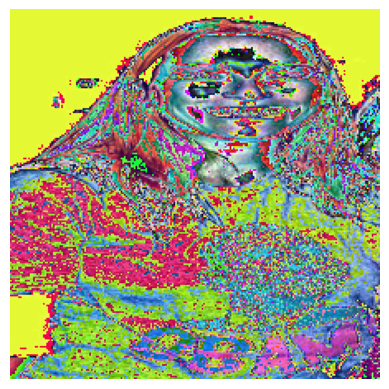

Denormalized Image:


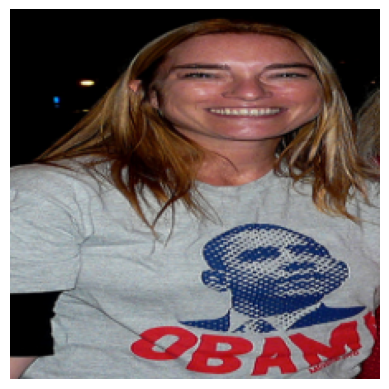

tensor([   2,   31,  465,  163,   78,   17,   74, 9572,  364,   34,   70,  141,
          11,   18,  107,    3])
Caption :
<sos> a blond haired girl in an obama t shirt is smiling at the camera <eos>


In [10]:
from src.utils import display_image

img, ids, cap_text = flickr_dataset[10366]
print("Normalized Image:")
display_image(img, denormalize=False)
print("Denormalized Image:")
display_image(img, denormalize=True, mean=mean, std=std)
print(ids)
print('Caption :')
print(vocab_builder.token_ids_to_caption(ids))

Defining dataloader for our dataset and also split dataset into train and test sets (80% train, 20% test)

In [11]:
train_size = int(0.91 * len(flickr_dataset))
val_size = int(0.045 * len(flickr_dataset))
test_size = len(flickr_dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(
    flickr_dataset, [train_size, val_size, test_size]
)

In [12]:
print(f"Number of training samples: {train_size}")
print(f"Number of validation samples: {val_size}")
print(f"Number of test samples: {test_size}")


Number of training samples: 28922
Number of validation samples: 1430
Number of test samples: 1431


In [13]:
from src.batch_caption_collator import BatchCaptionCollator

pad_idx = vocab_builder.vocabulary['<pad>']
batch_size = 48
num_workers = 4
prefetch_factor = 2

collator = BatchCaptionCollator(pad_idx=pad_idx, max_len=max_sentence_length, batch_first=True)


train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collator,
    num_workers=num_workers,
    prefetch_factor=prefetch_factor
)

val_loader = DataLoader(
    dataset=val_dataset,
    batch_size=batch_size,
    shuffle=False,
    collate_fn=collator,
    num_workers=num_workers,
    prefetch_factor=prefetch_factor
)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    shuffle=False,
    collate_fn=collator,
    num_workers=num_workers,
    prefetch_factor=prefetch_factor
)


## LSTM With Attention

In [14]:
vocab_size = len(vocab_builder.vocabulary)

emb_size = 300

attn_size = 128
drop_prob = 0.3
enc_hidden_size = 2048
dec_hidden_size = 1024

learning_rate = 1e-3
num_epochs = 100
print_every = 500

weight_decay = 1e-5

backbone="resnet50"

transformation=None

save_dir = "saved_model"

In [15]:
from src.models.encoderdecoder import EncoderDecoder

model_Attention = EncoderDecoder(
    emb_size = emb_size,
    vocab_size = vocab_size,
    attn_size = attn_size,
    enc_hidden_size = enc_hidden_size,
    dec_hidden_size = dec_hidden_size,
    drop_prob = drop_prob,
    device = device,
    use_attention=True,
    transformation=transformation
).to(device)

criterion = nn.CrossEntropyLoss(ignore_index = vocab['<pad>'])
optimizer = optim.Adam(model_Attention.parameters(), lr = learning_rate, weight_decay=weight_decay)

In [16]:
from src.utils import EarlyStopping

earlystopping_patience = 4

LR_patience = 2
LR_factor = 0.1


early_stopping = EarlyStopping(patience=earlystopping_patience, min_delta=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=LR_factor, patience=LR_patience, verbose=True)

Epoch: 1, Batch: 500, Training Loss: 3.82137


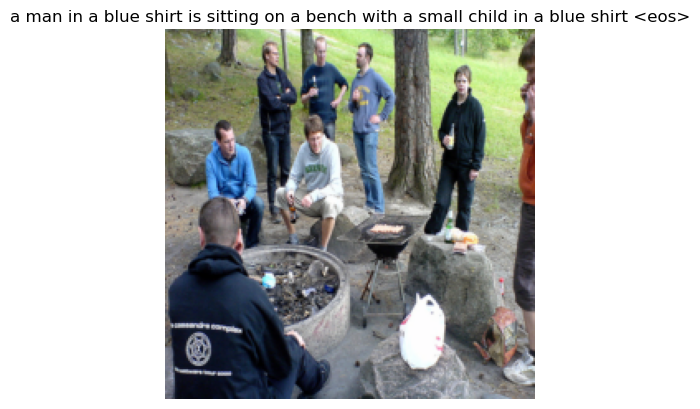

Epoch 1/100 - Train Loss: 4.2410, Val Loss: 3.6950, BLEU: 0.0495, ROUGE-1: 0.2913, ROUGE-2: 0.0834, ROUGE-L: 0.2559, ROUGE-Lsum: 0.2558
Saved checkpoint for epoch 1 at saved_model\LSTM_with_Attention_resnet50_None_epoch_1.pth.gz
Epoch: 2, Batch: 500, Training Loss: 3.27833


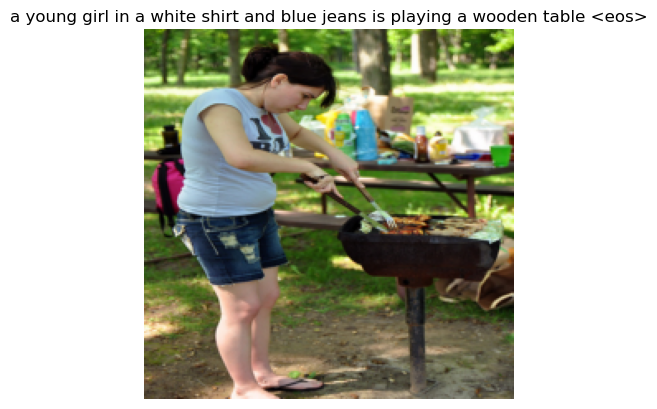

Epoch 2/100 - Train Loss: 3.4682, Val Loss: 3.4583, BLEU: 0.0539, ROUGE-1: 0.3047, ROUGE-2: 0.0919, ROUGE-L: 0.2647, ROUGE-Lsum: 0.2647
Saved checkpoint for epoch 2 at saved_model\LSTM_with_Attention_resnet50_None_epoch_2.pth.gz
Epoch: 3, Batch: 500, Training Loss: 3.16246


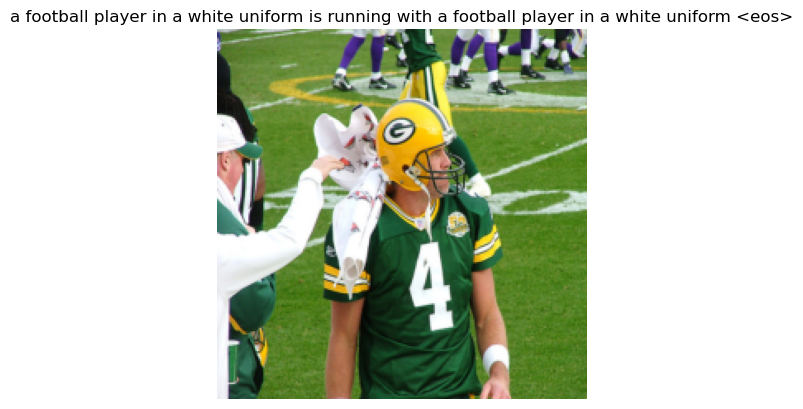

Epoch 3/100 - Train Loss: 3.1661, Val Loss: 3.3809, BLEU: 0.0615, ROUGE-1: 0.3148, ROUGE-2: 0.0955, ROUGE-L: 0.2745, ROUGE-Lsum: 0.2743
Saved checkpoint for epoch 3 at saved_model\LSTM_with_Attention_resnet50_None_epoch_3.pth.gz
Epoch: 4, Batch: 500, Training Loss: 3.20139


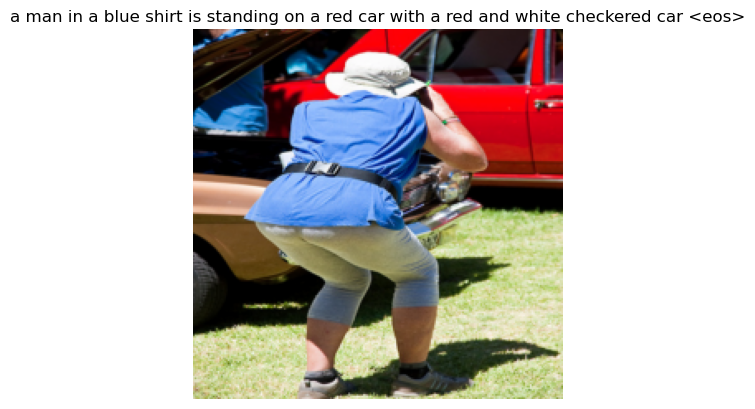

Epoch 4/100 - Train Loss: 2.9366, Val Loss: 3.3345, BLEU: 0.0618, ROUGE-1: 0.3150, ROUGE-2: 0.0970, ROUGE-L: 0.2736, ROUGE-Lsum: 0.2735
Saved checkpoint for epoch 4 at saved_model\LSTM_with_Attention_resnet50_None_epoch_4.pth.gz
Epoch: 5, Batch: 500, Training Loss: 2.74925


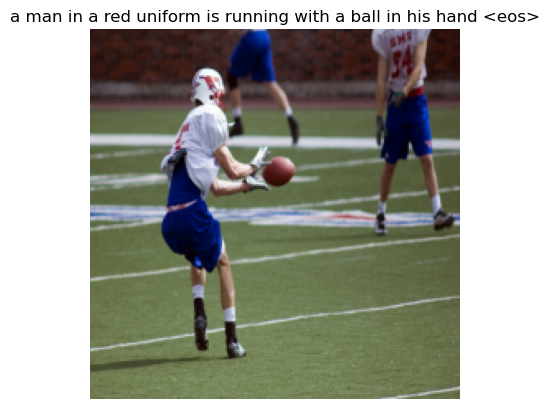

Epoch 5/100 - Train Loss: 2.7308, Val Loss: 3.3290, BLEU: 0.0614, ROUGE-1: 0.3160, ROUGE-2: 0.0977, ROUGE-L: 0.2723, ROUGE-Lsum: 0.2721
Saved checkpoint for epoch 5 at saved_model\LSTM_with_Attention_resnet50_None_epoch_5.pth.gz
Epoch: 6, Batch: 500, Training Loss: 2.61158


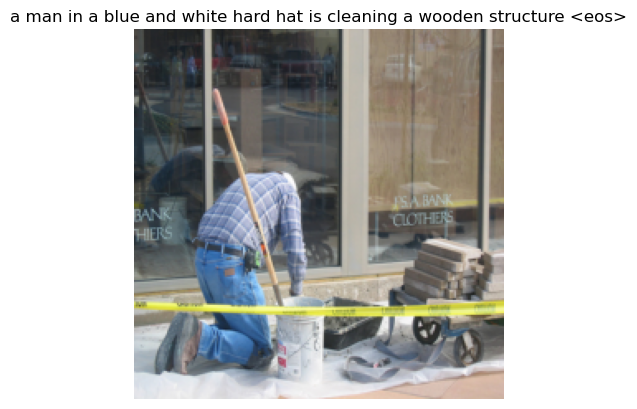

Epoch 6/100 - Train Loss: 2.5458, Val Loss: 3.3486, BLEU: 0.0598, ROUGE-1: 0.3167, ROUGE-2: 0.0956, ROUGE-L: 0.2713, ROUGE-Lsum: 0.2712
Saved checkpoint for epoch 6 at saved_model\LSTM_with_Attention_resnet50_None_epoch_6.pth.gz
Epoch: 7, Batch: 500, Training Loss: 2.49091


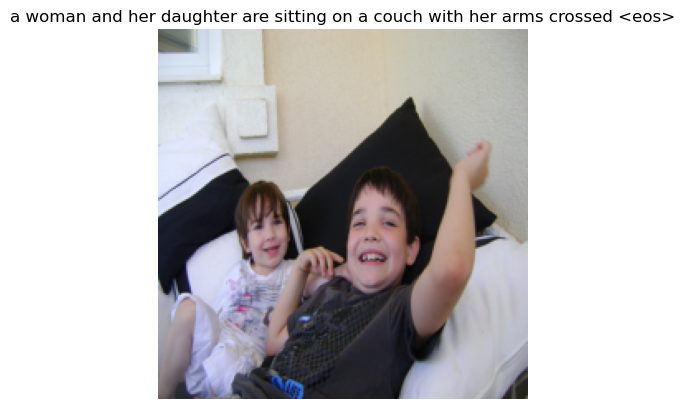

Epoch 7/100 - Train Loss: 2.3654, Val Loss: 3.3706, BLEU: 0.0602, ROUGE-1: 0.3201, ROUGE-2: 0.0934, ROUGE-L: 0.2734, ROUGE-Lsum: 0.2734
Saved checkpoint for epoch 7 at saved_model\LSTM_with_Attention_resnet50_None_epoch_7.pth.gz
Epoch: 8, Batch: 500, Training Loss: 2.22064


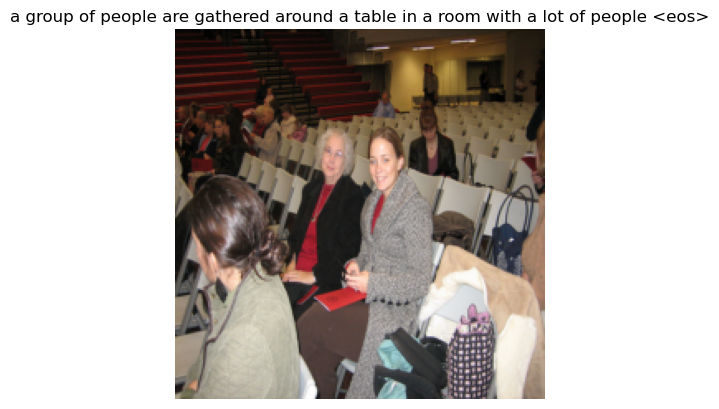

Epoch 8/100 - Train Loss: 2.1975, Val Loss: 3.4001, BLEU: 0.0624, ROUGE-1: 0.3150, ROUGE-2: 0.0955, ROUGE-L: 0.2725, ROUGE-Lsum: 0.2724
Epoch 00008: reducing learning rate of group 0 to 1.0000e-04.
Saved checkpoint for epoch 8 at saved_model\LSTM_with_Attention_resnet50_None_epoch_8.pth.gz
Epoch: 9, Batch: 500, Training Loss: 1.71015


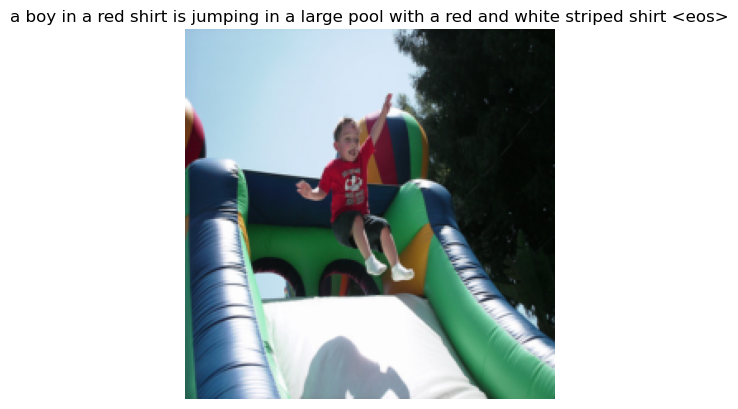

Epoch 9/100 - Train Loss: 1.7792, Val Loss: 3.4002, BLEU: 0.0613, ROUGE-1: 0.3188, ROUGE-2: 0.0961, ROUGE-L: 0.2722, ROUGE-Lsum: 0.2722
Saved checkpoint for epoch 9 at saved_model\LSTM_with_Attention_resnet50_None_epoch_9.pth.gz
Epoch: 10, Batch: 500, Training Loss: 1.76094


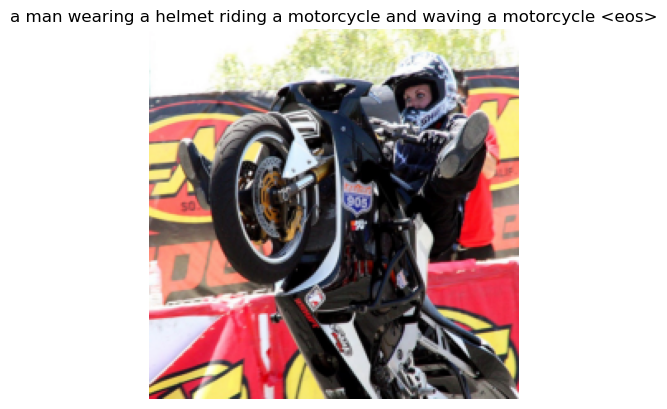

Epoch 10/100 - Train Loss: 1.6862, Val Loss: 3.4091, BLEU: 0.0615, ROUGE-1: 0.3189, ROUGE-2: 0.0964, ROUGE-L: 0.2738, ROUGE-Lsum: 0.2739
Early stopping triggered after epoch 10
Evaluating on the test set...
Test Results - Loss: 3.3766, BLEU: 0.0681, ROUGE-1: 0.3233, ROUGE-2: 0.1027, ROUGE-L: 0.2785, ROUGE-Lsum: 0.2784


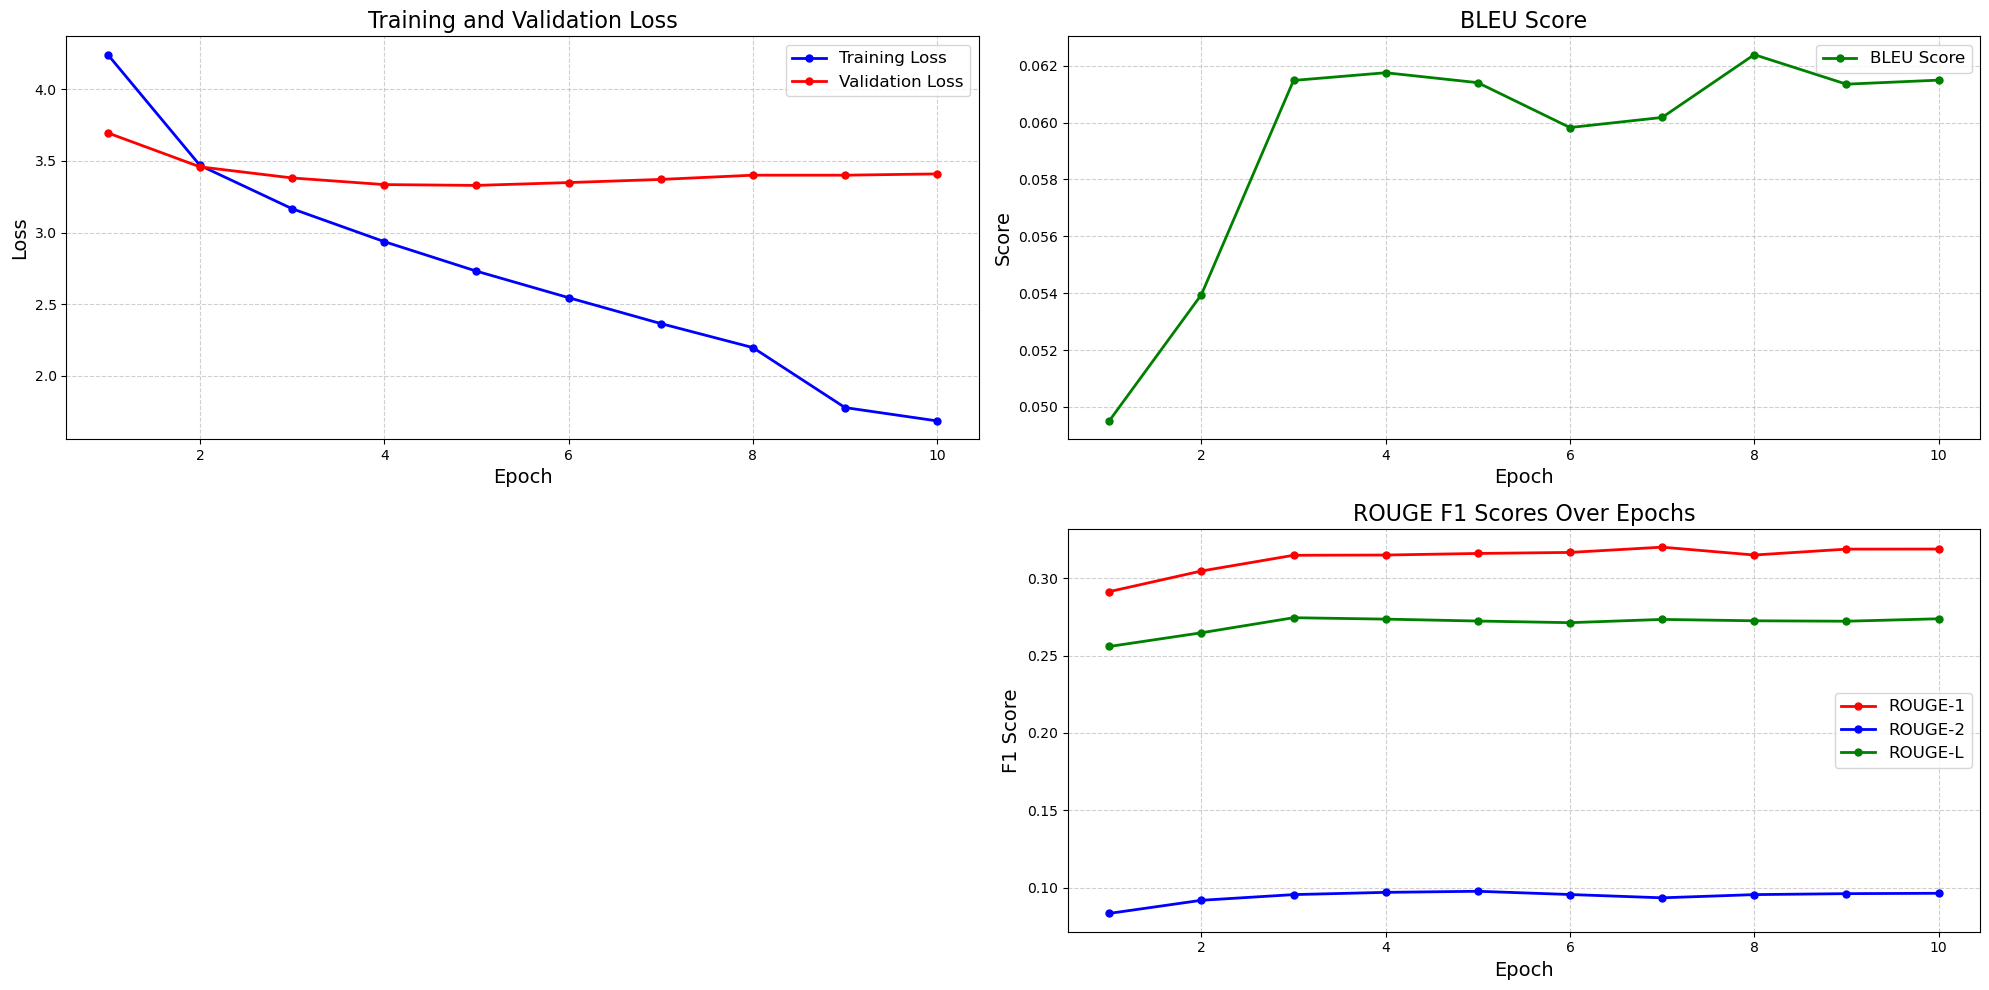

In [17]:
from src.utils import train_model

train_model(
    model=model_Attention,
    train_loader=train_loader,
    val_loader=val_loader,
    test_loader=test_loader,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    vocab=vocab,
    vocab_builder=vocab_builder,
    num_epochs=num_epochs,
    print_every=print_every,
    early_stopping=early_stopping,
    save_dir=save_dir,
    device=device,
    Transform_mean=mean,
    Transform_std=std,
    model_name="LSTM_with_Attention",
    max_sentence_length=max_sentence_length,
    encoder_backbone=backbone,
    transformation_type=transformation
)

## Generating captions from best model - Resnet50

In [1]:
import torch
from pathlib import Path
import os

if Path.cwd().name == 'notebooks':
    os.chdir("..")


from torchvision import transforms
from PIL import Image
from src.utils import load_model, display_image, visualize_attention
from src.models.encoderdecoder import EncoderDecoder
from src.vocab_builder import VocabularyBuilder

device = 'cuda' if torch.cuda.is_available() else 'cpu'

vocab_builder = VocabularyBuilder(min_freq=2, save_path='./saved_model/vocab_full.pth', special_token=True)
vocab = vocab_builder.load_vocab(device)

model_params = {
    "emb_size": 300,
    "vocab_size": len(vocab_builder.vocabulary),
    "attn_size": 128,
    "enc_hidden_size": 2048,
    "dec_hidden_size": 1024,
    "drop_prob": 0.3,
    "decoder_type": "lstm",
    "backbone": "resnet50",
    "transformation": None,
    "num_heads": None,
    "num_layers": None,
    "ff_dim": None,
    "max_len": 80,
    "use_attention": True,
    "device": device,
}

model = EncoderDecoder(**model_params)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)


checkpoint_path = "./saved_model/LSTM_with_Attention_resnet50_None_epoch_8.pth.gz"
model, optimizer, start_epoch = load_model(model, optimizer, checkpoint_path, device=device)

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

def generate_caption_for_image(image_path, visualize_atten=True):
    image = Image.open(image_path).convert("RGB")
    transformed_image = transform(image).unsqueeze(0).to(device)

    model.eval()
    with torch.no_grad():
        features = model.encoder(transformed_image)
        generated_caption, attention_weights = model.decoder.generate_caption(features=features, vocab=vocab)

    caption_text = " ".join(generated_caption)
    print(f"Generated Caption: {caption_text}")

    display_image(transformed_image.squeeze(0).cpu(), caption=caption_text, denormalize=True)

    if attention_weights and visualize_atten:
        visualize_attention(
            image=transformed_image.squeeze(0).cpu(),
            caption=generated_caption,
            attention_weights=attention_weights,
            mean=torch.tensor([0.485, 0.456, 0.406]),
            std=torch.tensor([0.229, 0.224, 0.225]),
            decoder_type='lstm',
            denormalize=True
        )


Loaded model from epoch 8


Processing: 25-R10500-P1-030.jpg
Generated Caption: a large group of people are gathered together in a row of a crowd of people <eos>


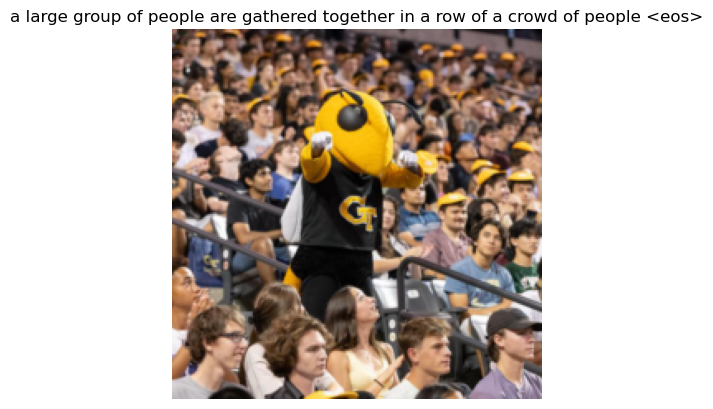

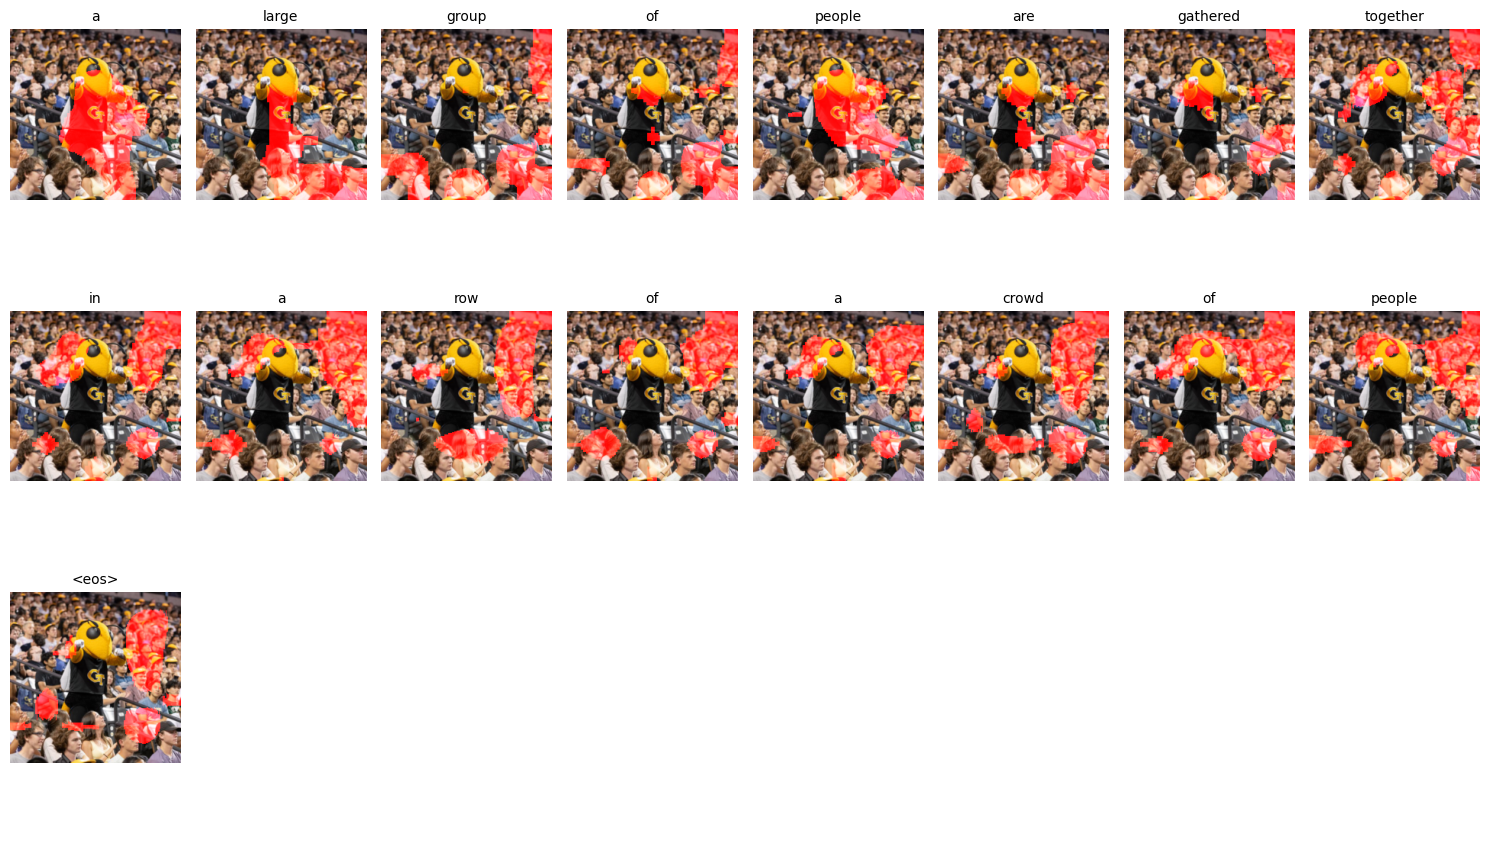

Processing: 53124280902_5077e9d833_w.jpg
Generated Caption: a young boy sitting in a yellow chair in a chair with a yellow and yellow striped comforter <eos>


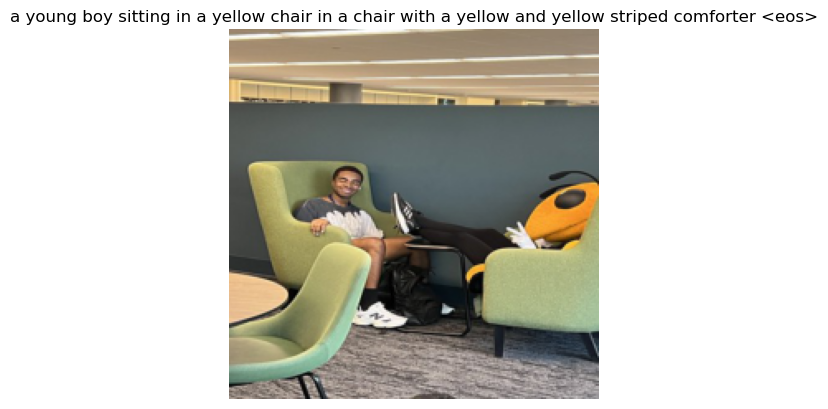

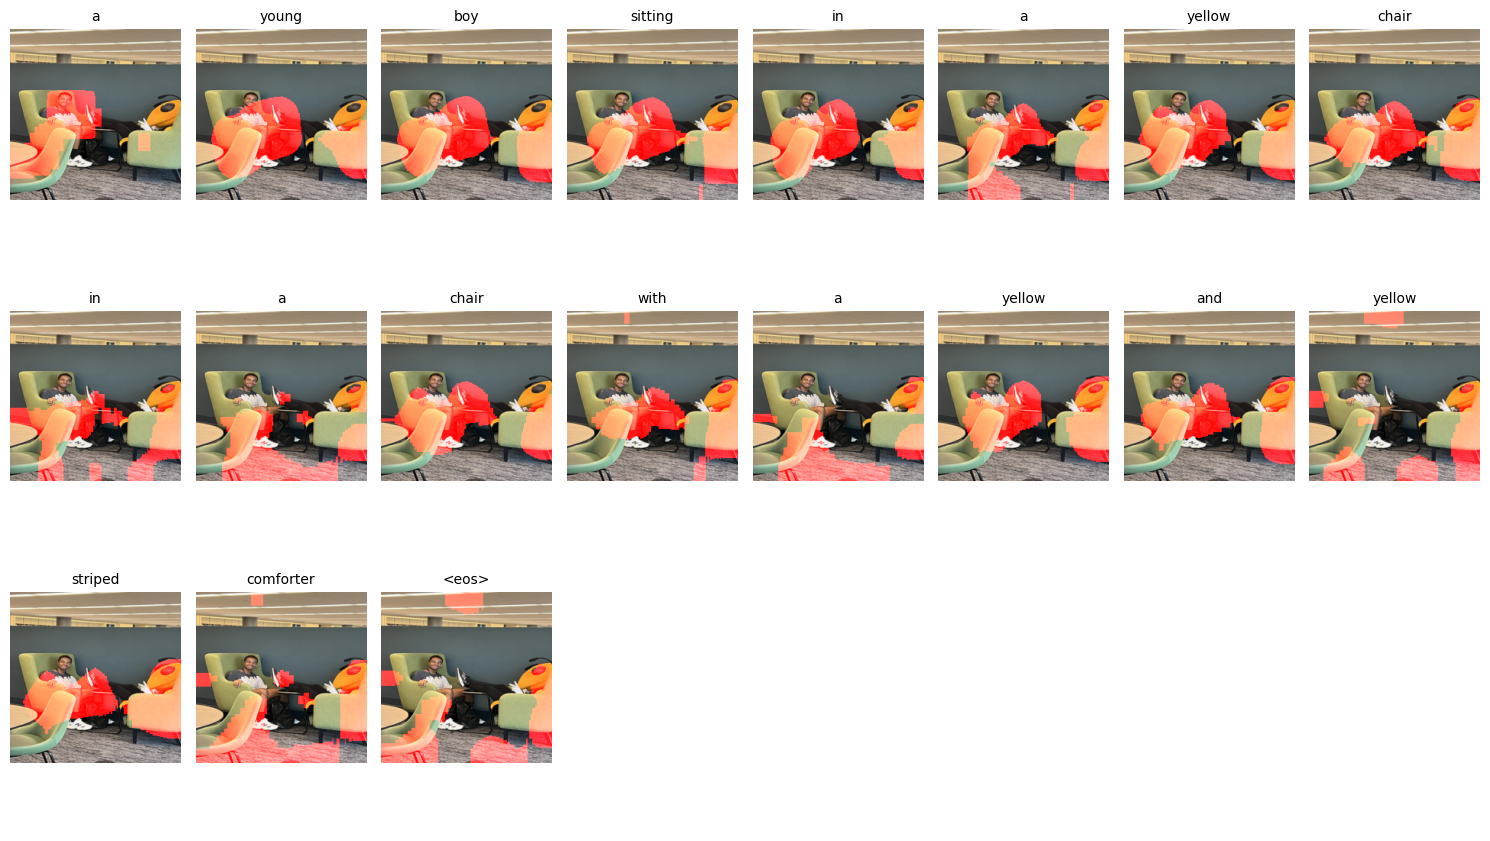

Processing: clough.jpg
Generated Caption: a man in a blue shirt walks past a building with a cityscape in the background <eos>


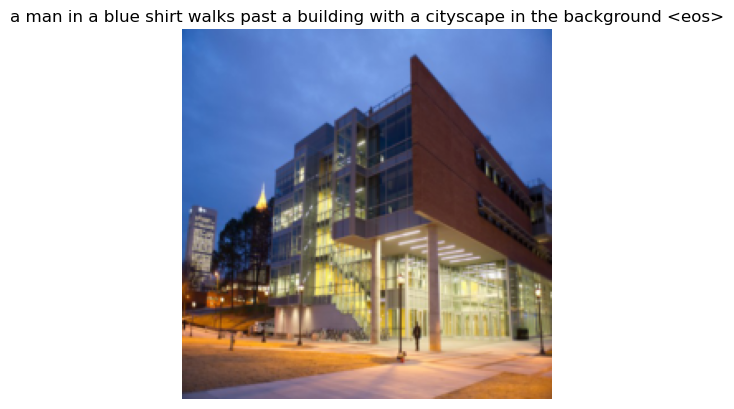

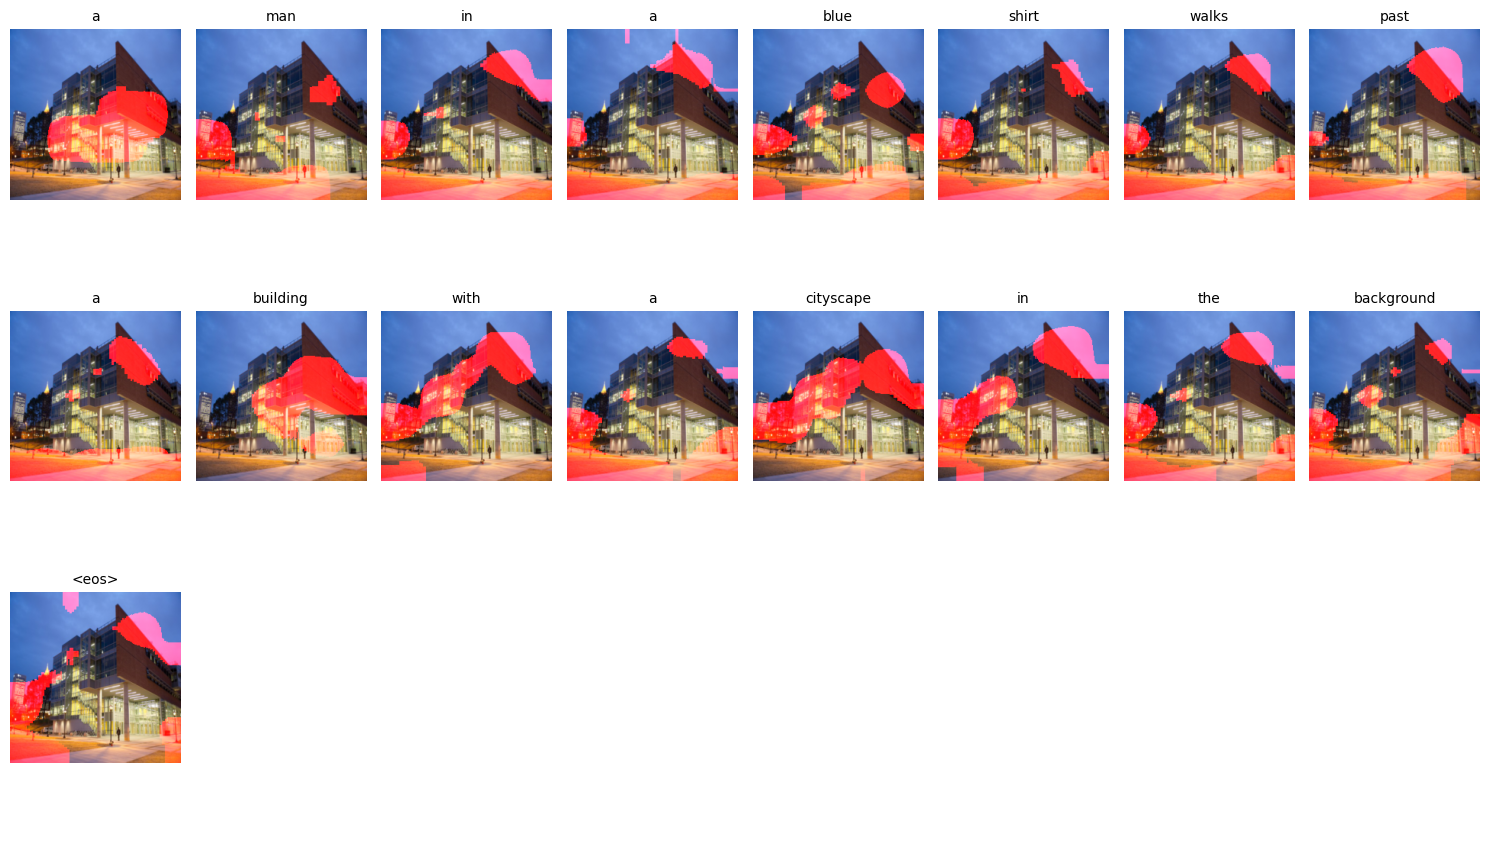

Processing: download.jpg
Generated Caption: a crowd of people in the background and a woman in a yellow shirt looks on <eos>


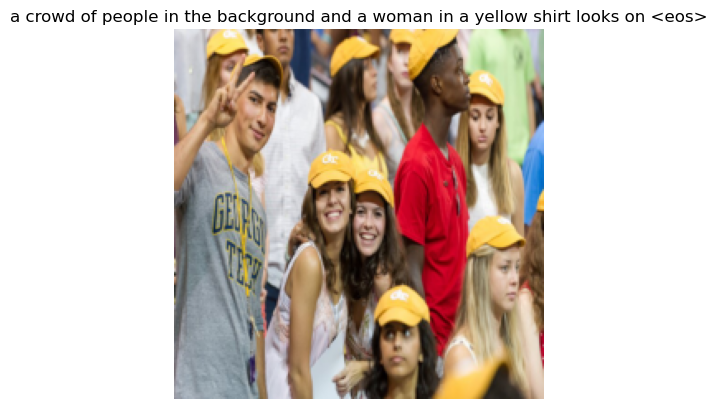

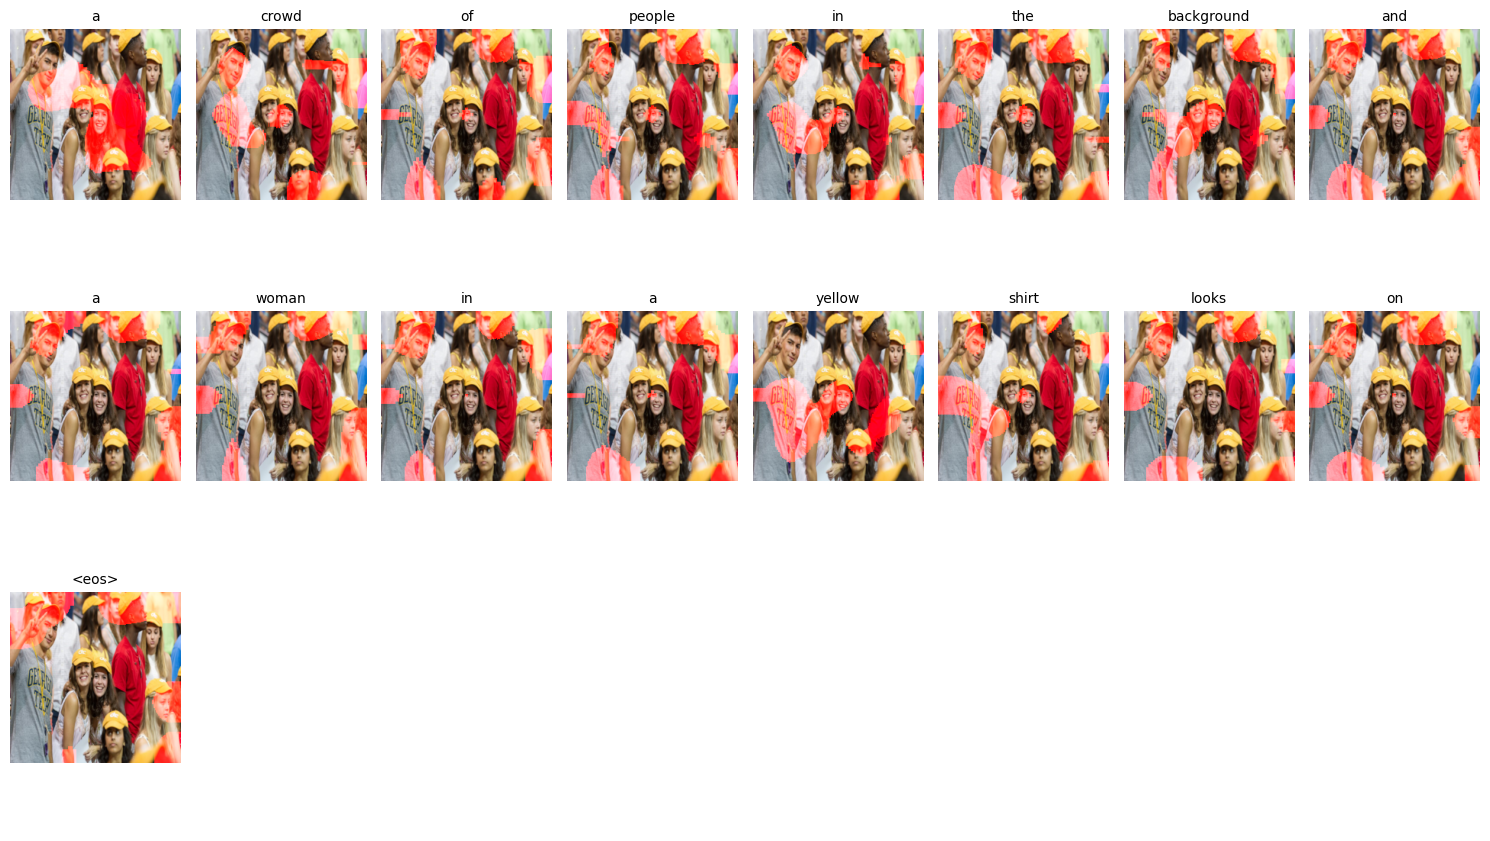

Processing: georgia tech georgia.jpg
Generated Caption: a football player in a red jersey is running with a football player in a white uniform <eos>


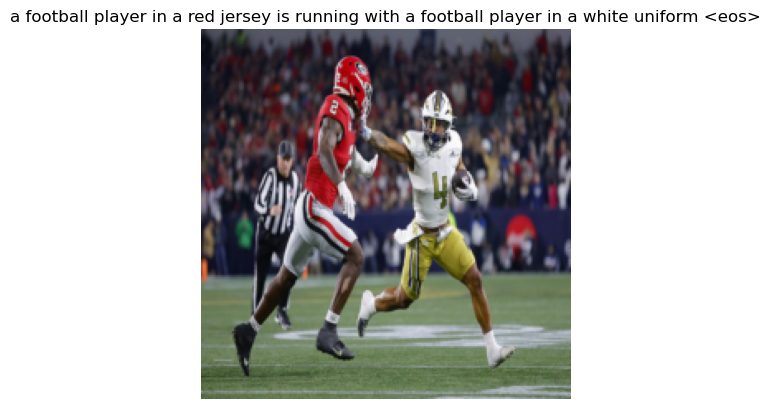

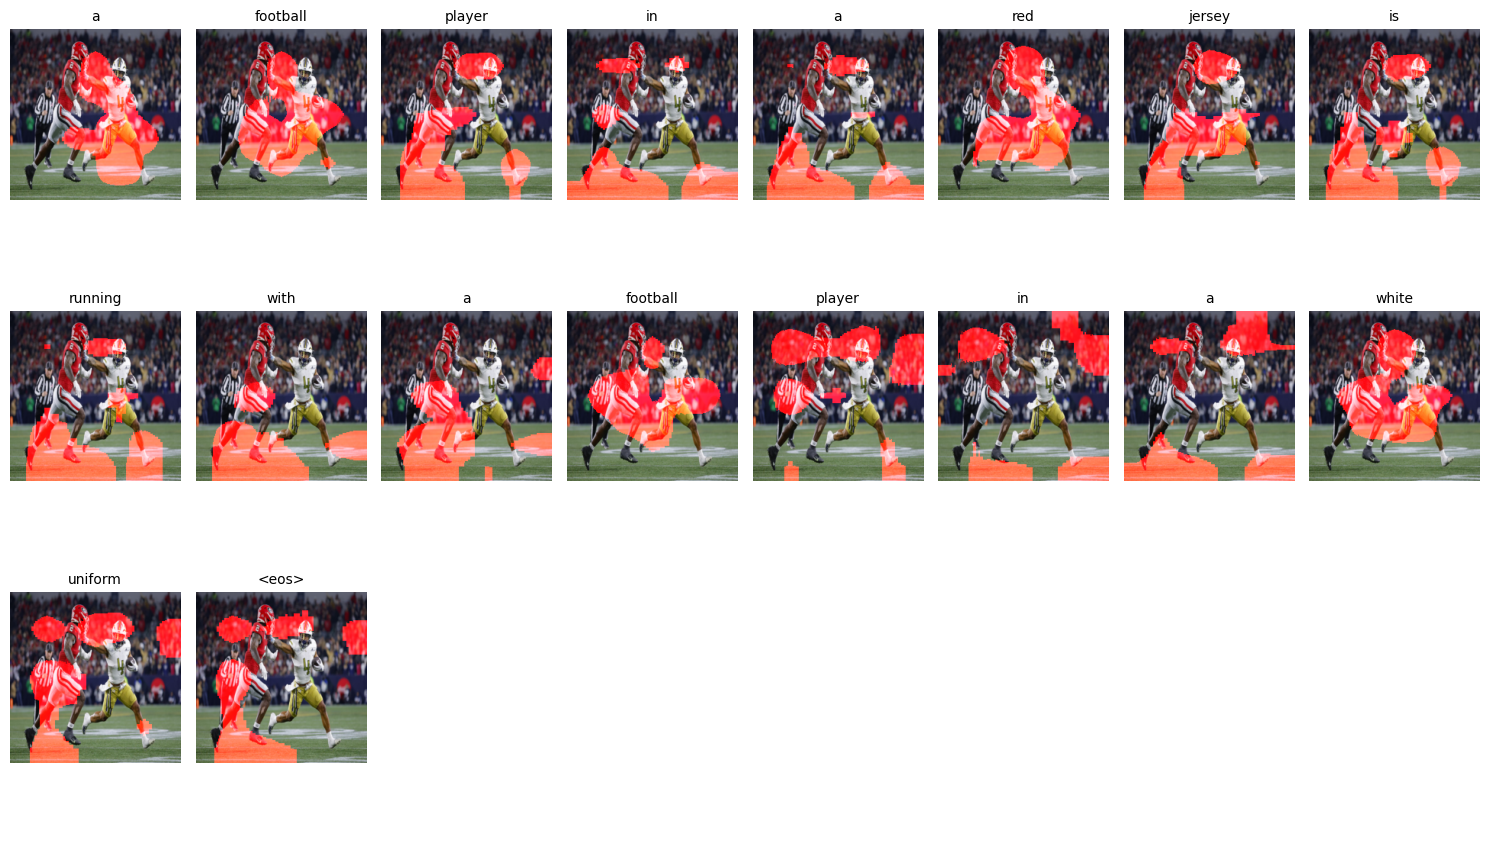

Processing: img_8914.jpg
Generated Caption: a man in a black shirt and jeans is sitting on a wooden bench in a park <eos>


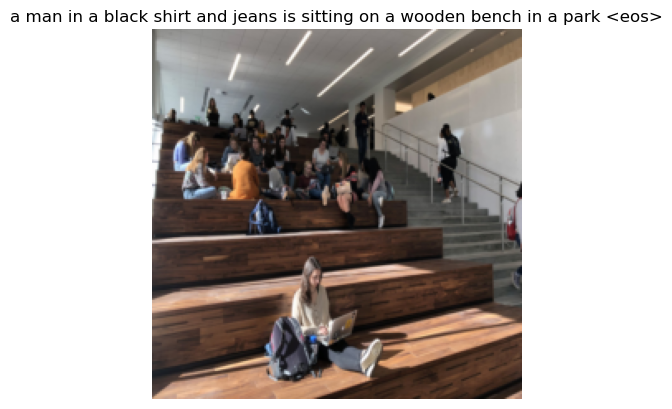

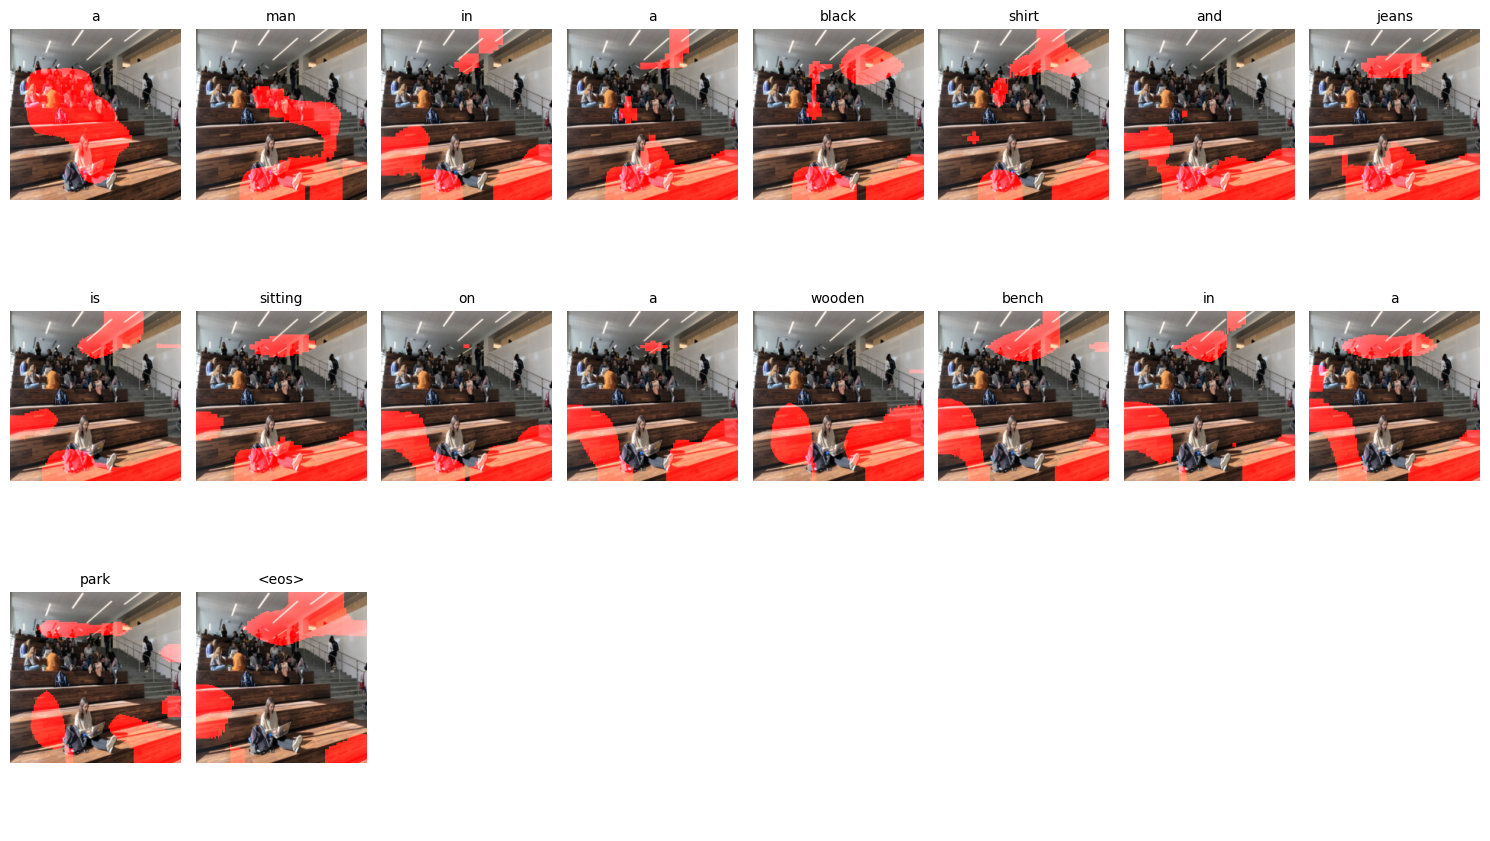

Processing: jumping1.jpg
Generated Caption: a group of young people are standing on a sidewalk looking at something in the distance <eos>


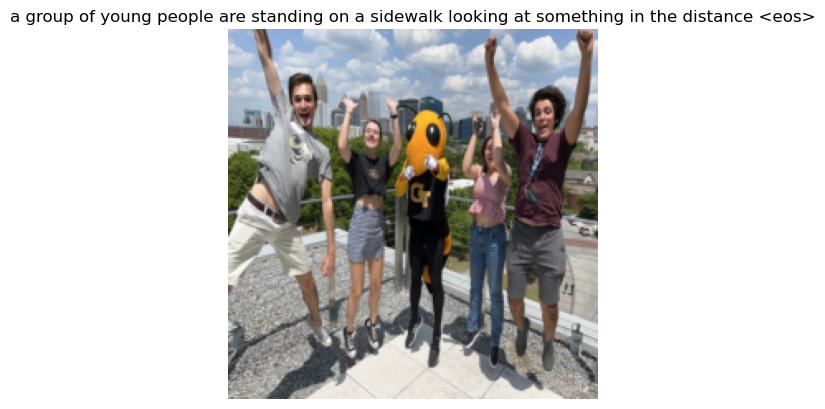

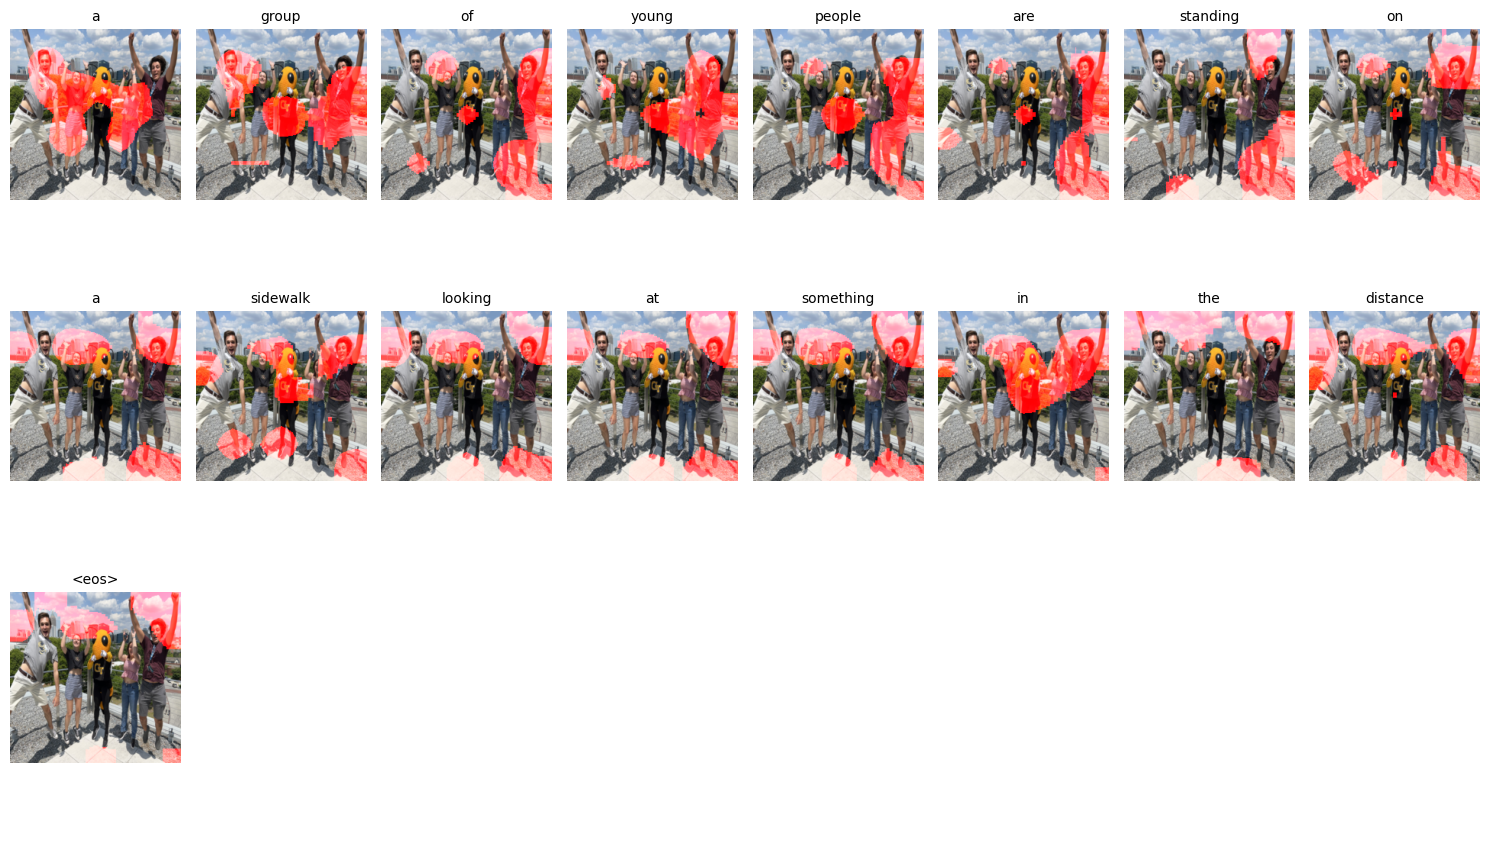

In [2]:
import os

folder_path = "./data/my_test/"

for image_file in os.listdir(folder_path):
    if image_file.endswith(".jpg"): 
        image_path = os.path.join(folder_path, image_file)
        print(f"Processing: {image_file}")
        generate_caption_for_image(image_path, visualize_atten=True)